# Snapchat Political Ads
* **See the main project notebook for instructions to be sure you satisfy the rubric!**
* See Project 03 for information on the dataset.
* A few example prediction questions to pursue are listed below. However, don't limit yourself to them!
    * Predict the reach (number of views) of an ad.
    * Predict how much was spent on an ad.
    * Predict the target group of an ad. (For example, predict the target gender.)
    * Predict the (type of) organization/advertiser behind an ad.

Be careful to justify what information you would know at the "time of prediction" and train your model using only those features.

# Summary of Findings


### Introduction
- Prediction Problem: **Regression problem to predict Impressions**. 
- Features that will be used to predict Impressions would be: 'Currency Code', 'Spend', 'Impressions', 'StartDate','EndDate', 'Gender', 'AgeBracket', 'CountryCode', 'Interests', and 'Language'
- The objective of the project is to increase accuracy measured by the R^2 score of the model.
- Since it is not a classification problem, we can ignore the Sensitivity and Specificity aspects of the model.

### Baseline Model
- Features
    - Quantitative: Spend
    - Ordinal: *None*
    - Nominal: CurrencyCode, CountryCode
- Notice how there are no ordinal features, for the baseline model.
- A lot of the initial features are taken away as they need to be engineered in order to be useful.
- Nominal Features will be one-hot encoded.
- **The R^2 score of the baseline model floats around 0.3 and 0.6 for the most part.**
- I think that the score value looks promising. It looks like most of the regression is done based on Spend, which makes sense since higher spending on the ad correlates directly with impressions observed.
- However, I think that the model can be improved by engineering additional features.

### Final Model
- Engineered Features:
    - MultiLabelBinarizer for OHE of Interests and Language: targeted interests of ads might play a role on the impressions it gets. Perhaps certain interests are taken more seriously for some viewers.
    - Duration derived from StartDate and EndDate. There should be a direct correlation between duration of the ads airtime and its impressions.
- Findings:
    - GridSearch on best parameter for categorical features PCA n_components (Currency Code, CountryCode, Interests, Language)
    - Discovered that all the categorical features are advised to be taken out.
    - Essentially back to baseline model but added imputation strategy for quantitative columns
    - Slight imporvement in R^2 score, better accuracy.

### Fairness Evaluation
- Compared the accuracy of the model for year 2019 and 2020.
- It seems to be doing better for the year 2019 than 2020 by quite a margin. 
- The mean R^2 value for the 2020 model is negative. 
- One reason to explain this is probably the fact that 2020 is still the current year so there is not sufficient data to model it. 
- Whereas 2019 data make up for most of the main dataset which created the model so it results in a higher accuracy.


# Code

### Data Cleaning

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

In [4]:
ads_19 = pd.read_csv('data/political_ads_19.csv')
ads_20 = pd.read_csv('data/political_ads_20.csv')

#### Concatenate the two different DataFrames from two different years.

In [6]:
data = pd.concat([ads_19, ads_20], ignore_index=True)
data.head()

,ADID,CreativeUrl,Currency Code,Spend,Impressions,StartDate,EndDate,OrganizationName,BillingAddress,CandidateBallotInformation,...,Location Categories (Included),Location Categories (Excluded),Interests,OsType,Segments,Language,AdvancedDemographics,Targeting Connection Type,Targeting Carrier (ISP),CreativeProperties
0,a18429b490a54c3fe6e9c726f9dc7279ea4d2d51285fc1...,https://www.snap.com/political-ads/asset/94e84...,GBP,8,4167,2019/11/26 00:00:06Z,2019/11/26 23:00:00Z,HOPE not hate Charitable Trust,"103-105 Blundell St,London,N7 9BN,GB",NaN,...,NaN,NaN,NaN,NaN,Provided by Advertiser,NaN,NaN,NaN,NaN,web_view_url:https://www.gov.uk/register-to-vote
1,4f322a3bfda8c0defb40b5880d5c1a1e92955059b201cd...,https://www.snap.com/political-ads/asset/fb0dd...,EUR,505,646878,2019/10/02 16:49:19Z,2019/10/23 21:59:26Z,ORIXA MEDIA,"79 Boulevard Richard Lenoir,PARIS,75011,FR",NaN,...,NaN,NaN,Political News Watchers,NaN,Provided by Advertiser,fr,NaN,NaN,NaN,web_view_url:https://reprenonslepouvoir.org?ut...
2,2f1481be8088238a3c653748920ff56f46061e6d0df74e...,https://www.snap.com/political-ads/asset/7d646...,EUR,186,179036,2019/08/12 08:30:41Z,2019/08/25 21:32:12Z,Reprise Media,"Skt. Petri Passage 52 ,København K,1165,DK",NaN,...,NaN,NaN,NaN,NaN,Provided by Advertiser,NaN,NaN,NaN,NaN,NaN
3,1579898f558416cbb3d7fe840d537cabeabf0e1d4432bf...,https://www.snap.com/political-ads/asset/1ad06...,GBP,4624,2909454,2019/05/21 11:51:56Z,2019/05/23 15:58:14Z,Avaaz Campaigns UK,GB,NaN,...,NaN,NaN,NaN,NaN,Provided by Advertiser,NaN,NaN,NaN,NaN,NaN
4,90dd24346e85cf696f5ac1573d7176989b844b380bba3c...,https://www.snap.com/political-ads/asset/52f99...,USD,1687,570706,2019/07/02 22:52:36Z,2019/07/31 22:52:36Z,Amélie Company,"2601 Blake St, Ste 150,Denver,80205,US",NaN,...,NaN,NaN,NaN,NaN,Provided by Advertiser,NaN,NaN,NaN,NaN,web_view_url:https://responsibilitygrowshere.c...


#### Convert StartDate and EndDate to datetime

In [8]:
# equals 1 means all values of 'StartDate' and 'EndDate' ends with 'Z'
[np.mean(data['StartDate'].apply(lambda x: str(x)[-1])=='Z'), \
 np.mean(data['StartDate'].apply(lambda x: str(x)[-1])=='Z')]

[1.0, 1.0]

The tailing 'Z' stands for Zulu Time, or GMT/UTC

In [9]:
data['StartDate'] = pd.to_datetime(data['StartDate'])
data['EndDate'] = pd.to_datetime(data['EndDate'])
data.head()

,ADID,CreativeUrl,Currency Code,Spend,Impressions,StartDate,EndDate,OrganizationName,BillingAddress,CandidateBallotInformation,...,Location Categories (Included),Location Categories (Excluded),Interests,OsType,Segments,Language,AdvancedDemographics,Targeting Connection Type,Targeting Carrier (ISP),CreativeProperties
0,a18429b490a54c3fe6e9c726f9dc7279ea4d2d51285fc1...,https://www.snap.com/political-ads/asset/94e84...,GBP,8,4167,2019-11-26 00:00:06+00:00,2019-11-26 23:00:00+00:00,HOPE not hate Charitable Trust,"103-105 Blundell St,London,N7 9BN,GB",NaN,...,NaN,NaN,NaN,NaN,Provided by Advertiser,NaN,NaN,NaN,NaN,web_view_url:https://www.gov.uk/register-to-vote
1,4f322a3bfda8c0defb40b5880d5c1a1e92955059b201cd...,https://www.snap.com/political-ads/asset/fb0dd...,EUR,505,646878,2019-10-02 16:49:19+00:00,2019-10-23 21:59:26+00:00,ORIXA MEDIA,"79 Boulevard Richard Lenoir,PARIS,75011,FR",NaN,...,NaN,NaN,Political News Watchers,NaN,Provided by Advertiser,fr,NaN,NaN,NaN,web_view_url:https://reprenonslepouvoir.org?ut...
2,2f1481be8088238a3c653748920ff56f46061e6d0df74e...,https://www.snap.com/political-ads/asset/7d646...,EUR,186,179036,2019-08-12 08:30:41+00:00,2019-08-25 21:32:12+00:00,Reprise Media,"Skt. Petri Passage 52 ,København K,1165,DK",NaN,...,NaN,NaN,NaN,NaN,Provided by Advertiser,NaN,NaN,NaN,NaN,NaN
3,1579898f558416cbb3d7fe840d537cabeabf0e1d4432bf...,https://www.snap.com/political-ads/asset/1ad06...,GBP,4624,2909454,2019-05-21 11:51:56+00:00,2019-05-23 15:58:14+00:00,Avaaz Campaigns UK,GB,NaN,...,NaN,NaN,NaN,NaN,Provided by Advertiser,NaN,NaN,NaN,NaN,NaN
4,90dd24346e85cf696f5ac1573d7176989b844b380bba3c...,https://www.snap.com/political-ads/asset/52f99...,USD,1687,570706,2019-07-02 22:52:36+00:00,2019-07-31 22:52:36+00:00,Amélie Company,"2601 Blake St, Ste 150,Denver,80205,US",NaN,...,NaN,NaN,NaN,NaN,Provided by Advertiser,NaN,NaN,NaN,NaN,web_view_url:https://responsibilitygrowshere.c...


In [15]:
# get columns (possible features)
data.columns

Index(['ADID', 'CreativeUrl', 'Currency Code', 'Spend', 'Impressions',
       'StartDate', 'EndDate', 'OrganizationName', 'BillingAddress',
       'CandidateBallotInformation', 'PayingAdvertiserName', 'Gender',
       'AgeBracket', 'CountryCode', 'Regions (Included)', 'Regions (Excluded)',
       'Electoral Districts (Included)', 'Electoral Districts (Excluded)',
       'Radius Targeting (Included)', 'Radius Targeting (Excluded)',
       'Metros (Included)', 'Metros (Excluded)', 'Postal Codes (Included)',
       'Postal Codes (Excluded)', 'Location Categories (Included)',
       'Location Categories (Excluded)', 'Interests', 'OsType', 'Segments',
       'Language', 'AdvancedDemographics', 'Targeting Connection Type',
       'Targeting Carrier (ISP)', 'CreativeProperties'],
      dtype='object')

In [16]:
# get first row for sample entry
data.iloc[0,:]

ADID                              a18429b490a54c3fe6e9c726f9dc7279ea4d2d51285fc1...
CreativeUrl                       https://www.snap.com/political-ads/asset/94e84...
Currency Code                                                                   GBP
Spend                                                                             8
Impressions                                                                    4167
StartDate                                                 2019-11-26 00:00:06+00:00
EndDate                                                   2019-11-26 23:00:00+00:00
OrganizationName                                     HOPE not hate Charitable Trust
BillingAddress                                 103-105 Blundell St,London,N7 9BN,GB
CandidateBallotInformation                                                      NaN
PayingAdvertiserName                                 HOPE not hate Charitable Trust
Gender                                                                      

In [17]:
# get proportion that is NaN and dtype of each column
for col in data.columns:
    print(col, data[col].isna().mean(), data[col].dtype)

ADID 0.0 object
CreativeUrl 0.0 object
Currency Code 0.0 object
Spend 0.0 int64
Impressions 0.0 int64
StartDate 0.0 datetime64[ns, UTC]
EndDate 0.22954128440366972 datetime64[ns, UTC]
OrganizationName 0.0 object
BillingAddress 0.0 object
CandidateBallotInformation 0.7770642201834862 object
PayingAdvertiserName 0.0 object
Gender 0.9233027522935779 object
AgeBracket 0.07834862385321101 object
CountryCode 0.0 object
Regions (Included) 0.7080733944954128 object
Regions (Excluded) 0.9710091743119266 object
Electoral Districts (Included) 0.9880733944954129 object
Electoral Districts (Excluded) 1.0 float64
Radius Targeting (Included) 0.9412844036697248 object
Radius Targeting (Excluded) 0.998165137614679 object
Metros (Included) 0.9609174311926606 object
Metros (Excluded) 0.996697247706422 object
Postal Codes (Included) 0.8434862385321101 object
Postal Codes (Excluded) 0.9737614678899082 object
Location Categories (Included) 0.9979816513761468 object
Location Categories (Excluded) 1.0 float64

Picking potential columns to be used as features for baseline model. Some columns cannot be used since it is mostly NaN or irrelevant with modeling (e.g. OrganizationName or BillingAddress).

In [45]:
feasible_feat_columns = ['Currency Code', 'Spend', 'Impressions', 'StartDate', 
                         'EndDate', 'Gender', 'AgeBracket', 
                         'CountryCode','Interests', 'Language']

In [47]:
data_filt = data[feasible_feat_columns]
data_filt.head()

,Currency Code,Spend,Impressions,StartDate,EndDate,Gender,AgeBracket,CountryCode,Interests,Language
0,GBP,8,4167,2019-11-26 00:00:06+00:00,2019-11-26 23:00:00+00:00,NaN,18-40,united kingdom,NaN,NaN
1,EUR,505,646878,2019-10-02 16:49:19+00:00,2019-10-23 21:59:26+00:00,NaN,17+,france,Political News Watchers,fr
2,EUR,186,179036,2019-08-12 08:30:41+00:00,2019-08-25 21:32:12+00:00,FEMALE,14-19,denmark,NaN,NaN
3,GBP,4624,2909454,2019-05-21 11:51:56+00:00,2019-05-23 15:58:14+00:00,NaN,18+,united kingdom,NaN,NaN
4,USD,1687,570706,2019-07-02 22:52:36+00:00,2019-07-31 22:52:36+00:00,NaN,18+,united states,NaN,NaN


Above is the DataFrame containing the baseline model features and the given Impressions.

### Baseline Model

In [146]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

Configuring Pipeline and applying OHE to categorical columns.

In [412]:
cats = Pipeline([
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])
catcols = ['Currency Code', 'CountryCode']

nums = FunctionTransformer(lambda x:x)   
numcols = ['Spend']

ct = ColumnTransformer([('cat', cats, catcols), ('num', nums, numcols)])

baseline_pl = Pipeline([('feats', ct), ('lr', LinearRegression())])


Initializing X and y columns and splitting train and test data. Training on train data, then test on test data.

In [413]:
X = data_filt.drop(['Impressions'], axis=1)
y = data_filt.Impressions

X_train, X_test, y_train, y_test = train_test_split(X, y)

baseline_pl.fit(X_train, y_train)

r2 = baseline_pl.score(X_test, y_test)
print("R^2: %s" % r2)

preds = baseline_pl.predict(X_test)
rmse = np.sqrt(np.mean((preds - y_test)**2))
print("RMSE: %s" % rmse)

R^2: 0.6728413730990455
RMSE: 1867746.8356924905


The R^2 score above looks promising b ut it looks like it can be improved with additional engineered features. Below is the process repeated 100 times to see the distribution of the fit score over 100 trials.

In [414]:
out = []
for _ in range(100):
    X_tr, X_ts, y_tr, y_ts = train_test_split(X, y)
    baseline_pl.fit(X_tr, y_tr)
    out.append(baseline_pl.score(X_ts, y_ts))
mean_r2 = np.mean(out)
print("Mean R^2 across 100 reps: %s" % mean_r2)

Mean R^2 across 100 reps: 0.5615195530471999


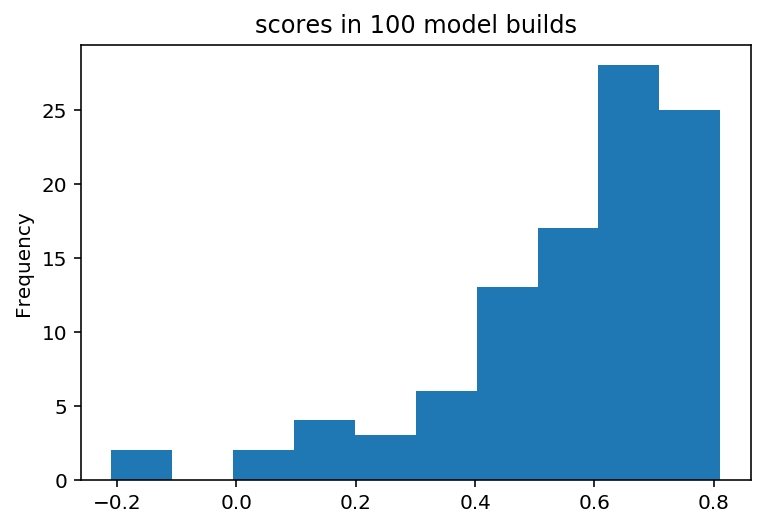

In [415]:
pd.Series(out).plot(kind='hist', title='scores in 100 model builds')

### Final Model

Below is a function to use the StartDate and EndDate features to generate a **Duration** feature of how long (in hours) the ad is up.

In [416]:
def get_duration_hours(df):
    duration = df['EndDate'] - df['StartDate']
    hours = duration.apply(lambda x: x.seconds//3600)
    return pd.DataFrame(hours)

Below is a function to use the Interests feature to set it up for the MultiLabelBinarizer by splitting interests on comma and performing a one-hot encoding later on.

In [417]:
def split_array(df): # of one column
    colname = df.columns[0]
    col = df[colname]
    ret = col.apply(lambda x: x.split(',') if pd.isnull(x)==False else [])
    return np.array(ret)

The class below is a custom transformer class I made because I encountered some error with implementing JultiLabelBinarizer directly to the pipeline. To be more specific, the fit_transform method requires 3 arguments, but only two are passed. Hence, this class fixes the issue by passing an empty argument everytime fit_transform is called on the Pipeline/ColumnTransformer.

In [418]:
from sklearn.base import TransformerMixin 
class MyMultiLabelBinarizer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = MultiLabelBinarizer(*args, **kwargs)
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    def transform(self, x, y=0):
        return self.encoder.transform(x)

#### First Trial Model

In [419]:
# Interests and Language
split = FunctionTransformer(split_array)
mlb_pl = Pipeline([
    ('split', split),
    ('mlb', MyLabelBinarizer()),
    ('pca', PCA(svd_solver='full'))  # later do gridsearch
])
mlbcols = ['Interests', 'Language']


# Currency Code and CountryCode
simple_cats = Pipeline([
    ('imp', SimpleImputer(strategy='constant', fill_value='NULL')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore')),
    ('pca', PCA(svd_solver='full'))  # later do gridsearch
])
simple_catcols = ['Currency Code', 'CountryCode']


# StartDate and EndDate
duration = FunctionTransformer(get_duration_hours)
duration_pl = Pipeline([
    ('get_hours', duration),
    ('imp', SimpleImputer(strategy='mean'))
])
durationcols = ['StartDate', 'EndDate']


# Spend
nums = FunctionTransformer(lambda x:x)   
numcols = ['Spend']

ct = ColumnTransformer([('mlb_cat', mlb_pl, mlbcols),
                        ('simple_cat', simple_cats, simple_catcols), 
                        ('duration', duration_pl, durationcols),
                        ('num', nums, numcols)
                       ])

trial_pl1 = Pipeline([('feats', ct), ('lr', LinearRegression())])

We will split the data set (75%, 25%) for train and test datasets.

In [420]:
X = data_filt.drop(['Impressions'], axis=1)
y = data_filt.Impressions

X_train, X_test, y_train, y_test = train_test_split(X, y)

GridSearch on n_components for simple_cat_pca

In [421]:
trial_pl1.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'feats', 'lr', 'feats__n_jobs', 'feats__remainder', 'feats__sparse_threshold', 'feats__transformer_weights', 'feats__transformers', 'feats__verbose', 'feats__mlb_cat', 'feats__simple_cat', 'feats__duration', 'feats__num', 'feats__mlb_cat__memory', 'feats__mlb_cat__steps', 'feats__mlb_cat__verbose', 'feats__mlb_cat__split', 'feats__mlb_cat__mlb', 'feats__mlb_cat__pca', 'feats__mlb_cat__split__accept_sparse', 'feats__mlb_cat__split__check_inverse', 'feats__mlb_cat__split__func', 'feats__mlb_cat__split__inv_kw_args', 'feats__mlb_cat__split__inverse_func', 'feats__mlb_cat__split__kw_args', 'feats__mlb_cat__split__validate', 'feats__mlb_cat__pca__copy', 'feats__mlb_cat__pca__iterated_power', 'feats__mlb_cat__pca__n_components', 'feats__mlb_cat__pca__random_state', 'feats__mlb_cat__pca__svd_solver', 'feats__mlb_cat__pca__tol', 'feats__mlb_cat__pca__whiten', 'feats__simple_cat__memory', 'feats__simple_cat__steps', 'feats__simple_cat__verbose', 'feats__

In [422]:
from sklearn.model_selection import GridSearchCV

params = {'feats__simple_cat__pca__n_components':[0.70, 0.75, 0.80, 0.85, 0.90, 0.99, None]}

# train using cross validation
grids1 = GridSearchCV(trial_pl1, param_grid=params, cv=5, iid = False)

In [423]:
grids1.fit(X_train, y_train)

/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Frequent International Travelers', 'Gift Shoppers', 'Holiday Online Buyers - Apparel', 'Holiday Online Shoppers', 'Home Movie Viewers (Science Fiction)', 'nln_8059'] will be ignored
  .format(sorted(unknown, key=str)))
/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Apparel Store Buyers - Charlotte Russe', 'Apparel Store Buyers - Express', 'Apparel Store Buyers - Guess', 'Apparel Store Buyers - H & M', 'Apparel Store Buyers - Michael Kors', 'Apparel Store Buyers - TJ Maxx', 'Apparel Store Buyers - Victorias Secret', 'Beauty and Fragrance Shoppers', "Women's Apparel Shoppers"] will be ignored
  .format(sorted(unknown, key=str)))
/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Baby & Toddler - Baby Food Buyers', '

/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Frequent International Travelers', 'Gift Shoppers', 'Holiday Online Buyers - Apparel', 'Holiday Online Shoppers', 'Home Movie Viewers (Science Fiction)', 'nln_8059'] will be ignored
  .format(sorted(unknown, key=str)))
/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Apparel Store Buyers - Charlotte Russe', 'Apparel Store Buyers - Express', 'Apparel Store Buyers - Guess', 'Apparel Store Buyers - H & M', 'Apparel Store Buyers - Michael Kors', 'Apparel Store Buyers - TJ Maxx', 'Apparel Store Buyers - Victorias Secret', 'Beauty and Fragrance Shoppers', "Women's Apparel Shoppers"] will be ignored
  .format(sorted(unknown, key=str)))
/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Baby & Toddler - Baby Food Buyers', '

/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Apparel Store Buyers - Charlotte Russe', 'Apparel Store Buyers - Express', 'Apparel Store Buyers - Guess', 'Apparel Store Buyers - H & M', 'Apparel Store Buyers - Michael Kors', 'Apparel Store Buyers - TJ Maxx', 'Apparel Store Buyers - Victorias Secret', 'Beauty and Fragrance Shoppers', "Women's Apparel Shoppers"] will be ignored
  .format(sorted(unknown, key=str)))
/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Baby & Toddler - Baby Food Buyers', 'Baby & Toddler - Baby Formula Buyers', 'Baby & Toddler - Baby HBC Buyers', 'Baby & Toddler - Baby HBC Buyers - Huggies Brands', 'Baby & Toddler - Disposable Diaper & Training Pant Buyers', 'Baby & Toddler - Disposable Diaper & Training Pant Buyers - Huggies Brands', 'Baby & Toddler - Disposable Diaper & Training Pant Buyers - Pampers Brands',

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('feats',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('mlb_cat',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('split',
                                                                                          FunctionTransformer(accept_sparse=False,
                                                                                                              check_inverse=True,
                    

In [424]:
grids1.best_params_

{'feats__simple_cat__pca__n_components': None}

This is interesting since the GridSearch tells us that the regression model will be better of if we drop the simple_cat features (Currency Code and CountryCode). So we will do so.

#### Second trial model

In [425]:
# Interests and Language
split = FunctionTransformer(split_array)
mlb_pl = Pipeline([
    ('split', split),
    ('mlb', MyLabelBinarizer()),
    ('pca', PCA(svd_solver='full'))  # later do gridsearch
])
mlbcols = ['Interests', 'Language']


# Currency Code and CountryCode
simple_cats = Pipeline([
    ('imp', SimpleImputer(strategy='constant', fill_value='NULL')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore')),
    ('pca', PCA(svd_solver='full', n_components=None))  
])
simple_catcols = ['Currency Code', 'CountryCode']


# StartDate and EndDate
duration = FunctionTransformer(get_duration_hours)
duration_pl = Pipeline([
    ('get_hours', duration),
    ('imp', SimpleImputer(strategy='mean'))
])
durationcols = ['StartDate', 'EndDate']


# Spend
nums = FunctionTransformer(lambda x:x)   
numcols = ['Spend']

ct = ColumnTransformer([('mlb_cat', mlb_pl, mlbcols),
                        ('simple_cat', simple_cats, simple_catcols),
                        ('duration', duration_pl, durationcols),
                        ('num', nums, numcols)
                       ])

trial_pl2 = Pipeline([('feats', ct), ('lr', LinearRegression())])

GridSearch on n_components of mlb_cat_pca

In [426]:
trial_pl2.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'feats', 'lr', 'feats__n_jobs', 'feats__remainder', 'feats__sparse_threshold', 'feats__transformer_weights', 'feats__transformers', 'feats__verbose', 'feats__mlb_cat', 'feats__simple_cat', 'feats__duration', 'feats__num', 'feats__mlb_cat__memory', 'feats__mlb_cat__steps', 'feats__mlb_cat__verbose', 'feats__mlb_cat__split', 'feats__mlb_cat__mlb', 'feats__mlb_cat__pca', 'feats__mlb_cat__split__accept_sparse', 'feats__mlb_cat__split__check_inverse', 'feats__mlb_cat__split__func', 'feats__mlb_cat__split__inv_kw_args', 'feats__mlb_cat__split__inverse_func', 'feats__mlb_cat__split__kw_args', 'feats__mlb_cat__split__validate', 'feats__mlb_cat__pca__copy', 'feats__mlb_cat__pca__iterated_power', 'feats__mlb_cat__pca__n_components', 'feats__mlb_cat__pca__random_state', 'feats__mlb_cat__pca__svd_solver', 'feats__mlb_cat__pca__tol', 'feats__mlb_cat__pca__whiten', 'feats__simple_cat__memory', 'feats__simple_cat__steps', 'feats__simple_cat__verbose', 'feats__

In [427]:
params = {'feats__mlb_cat__pca__n_components':[0.70, 0.75, 0.80, 0.85, 0.90, 0.99, None]}

# train using cross validation
grids2 = GridSearchCV(trial_pl2, param_grid=params, cv=5, iid = False)

In [428]:
grids2.fit(X_train, y_train)

/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Frequent International Travelers', 'Gift Shoppers', 'Holiday Online Buyers - Apparel', 'Holiday Online Shoppers', 'Home Movie Viewers (Science Fiction)', 'nln_8059'] will be ignored
  .format(sorted(unknown, key=str)))
/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Apparel Store Buyers - Charlotte Russe', 'Apparel Store Buyers - Express', 'Apparel Store Buyers - Guess', 'Apparel Store Buyers - H & M', 'Apparel Store Buyers - Michael Kors', 'Apparel Store Buyers - TJ Maxx', 'Apparel Store Buyers - Victorias Secret', 'Beauty and Fragrance Shoppers', "Women's Apparel Shoppers"] will be ignored
  .format(sorted(unknown, key=str)))
/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Baby & Toddler - Baby Food Buyers', '

/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Frequent International Travelers', 'Gift Shoppers', 'Holiday Online Buyers - Apparel', 'Holiday Online Shoppers', 'Home Movie Viewers (Science Fiction)', 'nln_8059'] will be ignored
  .format(sorted(unknown, key=str)))
/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Apparel Store Buyers - Charlotte Russe', 'Apparel Store Buyers - Express', 'Apparel Store Buyers - Guess', 'Apparel Store Buyers - H & M', 'Apparel Store Buyers - Michael Kors', 'Apparel Store Buyers - TJ Maxx', 'Apparel Store Buyers - Victorias Secret', 'Beauty and Fragrance Shoppers', "Women's Apparel Shoppers"] will be ignored
  .format(sorted(unknown, key=str)))
/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Baby & Toddler - Baby Food Buyers', '

/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Apparel Store Buyers - Charlotte Russe', 'Apparel Store Buyers - Express', 'Apparel Store Buyers - Guess', 'Apparel Store Buyers - H & M', 'Apparel Store Buyers - Michael Kors', 'Apparel Store Buyers - TJ Maxx', 'Apparel Store Buyers - Victorias Secret', 'Beauty and Fragrance Shoppers', "Women's Apparel Shoppers"] will be ignored
  .format(sorted(unknown, key=str)))
/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Baby & Toddler - Baby Food Buyers', 'Baby & Toddler - Baby Formula Buyers', 'Baby & Toddler - Baby HBC Buyers', 'Baby & Toddler - Baby HBC Buyers - Huggies Brands', 'Baby & Toddler - Disposable Diaper & Training Pant Buyers', 'Baby & Toddler - Disposable Diaper & Training Pant Buyers - Huggies Brands', 'Baby & Toddler - Disposable Diaper & Training Pant Buyers - Pampers Brands',

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('feats',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('mlb_cat',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('split',
                                                                                          FunctionTransformer(accept_sparse=False,
                                                                                                              check_inverse=True,
                    

In [429]:
grids2.best_params_

{'feats__mlb_cat__pca__n_components': 0.75}

With the Interests and Language features, we are also advised to take it out.

In [430]:
# Interests and Language
split = FunctionTransformer(split_array)
mlb_pl = Pipeline([
    ('split', split),
    ('mlb', MyLabelBinarizer()),
    ('pca', PCA(svd_solver='full', n_components=None))  
])
mlbcols = ['Interests', 'Language']


# Currency Code and CountryCode
simple_cats = Pipeline([
    ('imp', SimpleImputer(strategy='constant', fill_value='NULL')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore')),
    ('pca', PCA(svd_solver='full', n_components=None))  
])
simple_catcols = ['Currency Code', 'CountryCode']


# StartDate and EndDate
duration = FunctionTransformer(get_duration_hours)
duration_pl = Pipeline([
    ('get_hours', duration),
    ('imp', SimpleImputer(strategy='median'))
])
durationcols = ['StartDate', 'EndDate']


# Spend
nums = FunctionTransformer(lambda x:x)   
numcols = ['Spend']

ct = ColumnTransformer([('mlb_cat', mlb_pl, mlbcols),
                        ('simple_cat', simple_cats, simple_catcols),
                        ('duration', duration_pl, durationcols),
                        ('num', nums, numcols)
                       ])

final_pl = Pipeline([('feats', ct), ('lr', LinearRegression())])

We will now train the model and predict.

In [434]:
X = data_filt.drop(['Impressions'], axis=1)
y = data_filt.Impressions

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)

final_pl.fit(X_train, y_train)

r2 = final_pl.score(X_test, y_test)
print("R^2: %s" % r2)

final_preds = final_pl.predict(X_test)
rmse = np.sqrt(np.mean((final_preds - y_test)**2))
print("RMSE: %s" % rmse)

R^2: 0.6937881160154702
RMSE: 4357424.355017208


/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Apparel Store Buyers - Charlotte Russe', 'Apparel Store Buyers - Express', 'Apparel Store Buyers - Guess', 'Apparel Store Buyers - H & M', 'Apparel Store Buyers - Michael Kors', 'Apparel Store Buyers - TJ Maxx', 'Apparel Store Buyers - Victorias Secret', 'Beauty and Fragrance Shoppers', 'Drama Genre Fans', 'Home Movie Viewers (Science Fiction)', 'Indie & Alternative Music Fans', 'Mexican Food Shoppers', 'Rock Music Fans', 'Soul & R&B Fans', 'TV Viewers (Educational)', "Women's Apparel Shoppers"] will be ignored
  .format(sorted(unknown, key=str)))
/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Apparel Store Buyers - Charlotte Russe', 'Apparel Store Buyers - Express', 'Apparel Store Buyers - Guess', 'Apparel Store Buyers - H & M', 'Apparel Store Buyers - Michael Kors', 'Apparel Store Buy

In [432]:
out = []
for _ in range(100):
    X_tr, X_ts, y_tr, y_ts = train_test_split(X, y)
    final_pl.fit(X_tr, y_tr)
    out.append(final_pl.score(X_ts, y_ts))
mean_r2 = np.mean(out)
print("Mean R^2 across 100 reps: %s" % mean_r2)

/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ["Men's Apparel Shoppers", 'Sporting Goods Buyers - Bass Pro Shop', 'Sporting Goods Buyers - Cabelas', 'TV Light Viewers'] will be ignored
  .format(sorted(unknown, key=str)))
/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Apparel Buyers', 'Baby & Toddler - Baby Food Buyers', 'Baby & Toddler - Baby Formula Buyers', 'Baby & Toddler - Baby HBC Buyers', 'Baby & Toddler - Baby HBC Buyers - Huggies Brands', 'Baby & Toddler - Disposable Diaper & Training Pant Buyers', 'Baby & Toddler - Disposable Diaper & Training Pant Buyers - Huggies Brands', 'Baby & Toddler - Disposable Diaper & Training Pant Buyers - Pampers Brands', 'Baby Product Buyers', 'Baby Store Buyers', 'Baby Store Buyers - Buy Buy Baby', 'Baby Store Buyers - Carters', 'Baby Store Buyers - Diapers.com', 'Black Friday & Cyber Monday S

/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Black Friday & Cyber Monday Shoppers', 'Drama Genre Fans', 'Indie & Alternative Music Fans', 'Mexican Food Shoppers', 'Post-Holiday Bargain Shoppers', 'Rock Music Fans', 'TV Network Viewers (FX)'] will be ignored
  .format(sorted(unknown, key=str)))
/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Home Movie Viewers (Science Fiction)', "Men's Apparel Shoppers", 'Mexican Food Shoppers', 'Soul & R&B Fans', 'Sporting Goods Buyers - Bass Pro Shop', 'Sporting Goods Buyers - Cabelas', 'Supermarket Buyers - Whole Foods Market', 'TV Light Viewers'] will be ignored
  .format(sorted(unknown, key=str)))
/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Apparel Store Buyers - Charlotte Russe', 'Apparel Store Buyers - Express',

/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Apparel Store Buyers - Charlotte Russe', 'Apparel Store Buyers - Express', 'Apparel Store Buyers - Guess', 'Apparel Store Buyers - H & M', 'Apparel Store Buyers - Michael Kors', 'Apparel Store Buyers - TJ Maxx', 'Apparel Store Buyers - Victorias Secret', 'Beauty and Fragrance Shoppers', 'Big Box Store Buyers - Walmart', 'Independence Day Buyers - Furnishing Stores', 'Independence Day Buyers - Grocery', 'Labor Day Buyers - Clothing Stores', 'Last 12 Months Buyers - Walmart', "Women's Apparel Shoppers"] will be ignored
  .format(sorted(unknown, key=str)))
/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Apparel Buyers', 'Apparel Store Buyers - Charlotte Russe', 'Apparel Store Buyers - Express', 'Apparel Store Buyers - Guess', 'Apparel Store Buyers - H & M', 'Apparel Store Buyers - Michael K

/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Apparel Store Buyers - Charlotte Russe', 'Apparel Store Buyers - Express', 'Apparel Store Buyers - Guess', 'Apparel Store Buyers - H & M', 'Apparel Store Buyers - Michael Kors', 'Apparel Store Buyers - TJ Maxx', 'Apparel Store Buyers - Victorias Secret', 'Beauty and Fragrance Shoppers', 'Big Box Store Buyers - Walmart', 'Last 12 Months Buyers - Walmart', "Men's Apparel Shoppers", 'Pet Owners', 'Sporting Goods Buyers - Bass Pro Shop', 'Sporting Goods Buyers - Cabelas', 'TV Light Viewers', 'TV Viewers (Science Fiction & Fantasy)', "Women's Apparel Shoppers", 'nln_8059'] will be ignored
  .format(sorted(unknown, key=str)))
/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Apparel Store Buyers - Charlotte Russe', 'Apparel Store Buyers - Express', 'Apparel Store Buyers - Guess', 'Apparel Store 

/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Apparel Store Buyers - Charlotte Russe', 'Apparel Store Buyers - Express', 'Apparel Store Buyers - Guess', 'Apparel Store Buyers - H & M', 'Apparel Store Buyers - Michael Kors', 'Apparel Store Buyers - TJ Maxx', 'Apparel Store Buyers - Victorias Secret', 'Baby & Toddler - Baby Food Buyers', 'Baby & Toddler - Baby Formula Buyers', 'Baby & Toddler - Baby HBC Buyers', 'Baby & Toddler - Baby HBC Buyers - Huggies Brands', 'Baby & Toddler - Disposable Diaper & Training Pant Buyers', 'Baby & Toddler - Disposable Diaper & Training Pant Buyers - Huggies Brands', 'Baby & Toddler - Disposable Diaper & Training Pant Buyers - Pampers Brands', 'Baby Product Buyers', 'Baby Store Buyers', 'Baby Store Buyers - Buy Buy Baby', 'Baby Store Buyers - Carters', 'Baby Store Buyers - Diapers.com', 'Beauty and Fragrance Shoppers', "Children's Product Buyers", "Children's Product Shoppers"

/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Apparel Store Buyers - Charlotte Russe', 'Apparel Store Buyers - Express', 'Apparel Store Buyers - Guess', 'Apparel Store Buyers - H & M', 'Apparel Store Buyers - Michael Kors', 'Apparel Store Buyers - TJ Maxx', 'Apparel Store Buyers - Victorias Secret', 'Baby & Toddler - Baby Food Buyers', 'Baby & Toddler - Baby Formula Buyers', 'Baby & Toddler - Baby HBC Buyers', 'Baby & Toddler - Baby HBC Buyers - Huggies Brands', 'Baby & Toddler - Disposable Diaper & Training Pant Buyers', 'Baby & Toddler - Disposable Diaper & Training Pant Buyers - Huggies Brands', 'Baby & Toddler - Disposable Diaper & Training Pant Buyers - Pampers Brands', 'Baby Product Buyers', 'Baby Store Buyers', 'Baby Store Buyers - Buy Buy Baby', 'Baby Store Buyers - Carters', 'Baby Store Buyers - Diapers.com', 'Beauty and Fragrance Shoppers', 'Big Box Store Buyers - Walmart', "Children's Product Buye

/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Big Box Shoppers', 'Black Friday & Cyber Monday Shoppers', 'Department Store Shoppers', 'Family Travelers', 'Post-Holiday Bargain Shoppers', 'TV Network Viewers (FX)', 'Theme Park Visitors', 'Toy Shoppers'] will be ignored
  .format(sorted(unknown, key=str)))
/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Apparel Store Buyers - Charlotte Russe', 'Apparel Store Buyers - Express', 'Apparel Store Buyers - Guess', 'Apparel Store Buyers - H & M', 'Apparel Store Buyers - Michael Kors', 'Apparel Store Buyers - TJ Maxx', 'Apparel Store Buyers - Victorias Secret', 'Baby & Toddler - Baby Food Buyers', 'Baby & Toddler - Baby Formula Buyers', 'Baby & Toddler - Baby HBC Buyers', 'Baby & Toddler - Baby HBC Buyers - Huggies Brands', 'Baby & Toddler - Disposable Diaper & Training Pant Buyers', 'Baby & 

/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Black Friday & Cyber Monday Shoppers', 'Pet Owners', 'Post-Holiday Bargain Shoppers', 'TV Network Viewers (Discovery Channel)', 'TV Network Viewers (FX)'] will be ignored
  .format(sorted(unknown, key=str)))
/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Apparel Store Buyers - Charlotte Russe', 'Apparel Store Buyers - Express', 'Apparel Store Buyers - Guess', 'Apparel Store Buyers - H & M', 'Apparel Store Buyers - Michael Kors', 'Apparel Store Buyers - TJ Maxx', 'Apparel Store Buyers - Victorias Secret', 'Beauty and Fragrance Shoppers', 'Independence Day Buyers - Furnishing Stores', 'Independence Day Buyers - Grocery', 'Labor Day Buyers - Clothing Stores', "Women's Apparel Shoppers"] will be ignored
  .format(sorted(unknown, key=str)))
/Users/jonathant/anaconda3/lib/python3.7/site-packa

Mean R^2 across 100 reps: 0.4937744233152354


/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Big Box Store Buyers - Walmart', 'Last 12 Months Buyers - Walmart', "Men's Apparel Shoppers", 'Sporting Goods Buyers - Bass Pro Shop', 'Sporting Goods Buyers - Cabelas'] will be ignored
  .format(sorted(unknown, key=str)))


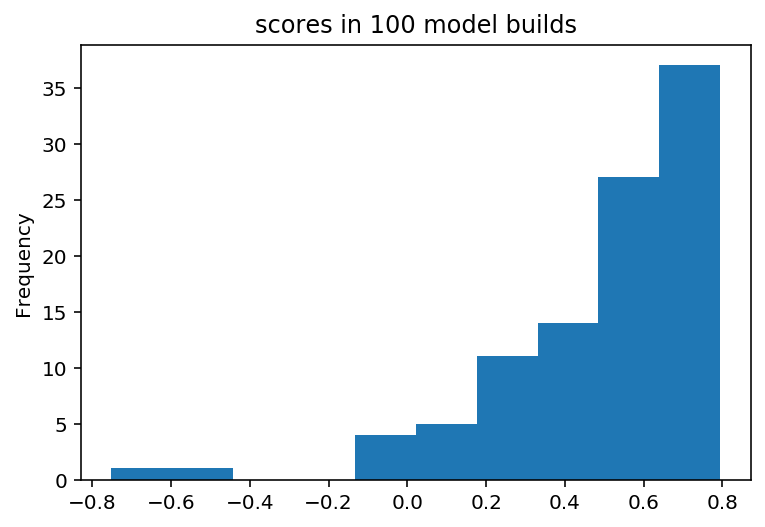

In [433]:
pd.Series(out).plot(kind='hist', title='scores in 100 model builds')

#### We see here that there has been a bit of an increase in accuracy from the baseline model to the final model going from 0.56 to 0.69.

### Fairness Evaluation

I will evaluate how fair the model is for regression on ads data in 2019 and 2020.

In [439]:
filt19 = data_filt['StartDate'].apply(lambda x: x.year==2019)
data_19 = data_filt[filt19.values]

filt20 = data_filt['StartDate'].apply(lambda x: x.year==2020)
data_20 = data_filt[filt20.values]

#### On 2019

In [447]:
X19 = data_19.drop(['Impressions'], axis=1)
y19 = data_19.Impressions

X_train, X_test, y_train, y_test = train_test_split(X19, y19, test_size=.25)

final_pl.fit(X_train, y_train)

print(2019)
r2 = final_pl.score(X_test, y_test)
print("R^2: %s" % r2)

final_preds = final_pl.predict(X_test)
rmse = np.sqrt(np.mean((final_preds - y_test)**2))
print("RMSE: %s" % rmse)

2019
R^2: 0.7297120416759013
RMSE: 4437666.785179717


/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Country Music Fans'] will be ignored
  .format(sorted(unknown, key=str)))
/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Country Music Fans'] will be ignored
  .format(sorted(unknown, key=str)))


In [448]:
out = []
for _ in range(100):
    X_tr, X_ts, y_tr, y_ts = train_test_split(X19, y19)
    final_pl.fit(X_tr, y_tr)
    out.append(final_pl.score(X_ts, y_ts))
mean_r2 = np.mean(out)
print("Mean R^2 across 100 reps: %s" % mean_r2)

/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Hybrid & Alternative Vehicle Shoppers', 'TV Viewers (Comedy)'] will be ignored
  .format(sorted(unknown, key=str)))
/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Dining Establishment Visitors', 'Grocery Shoppers', 'Home & Garden Shoppers', 'Retail Store Visitors', 'Seasonal Shoppers', 'TV Light Viewers'] will be ignored
  .format(sorted(unknown, key=str)))
/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['TV Light Viewers', 'TV Viewers (Educational)', 'nln_8059'] will be ignored
  .format(sorted(unknown, key=str)))
/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Electronics Buyers - Apple Store', 'Last 12 Months Buyers - Apple', 'TV Vie

/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Olympics Enthusiasts', 'TV Viewers (Educational)', 'Talent & Competition Show Fans', 'nln_8059'] will be ignored
  .format(sorted(unknown, key=str)))
/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Hybrid & Alternative Vehicle Shoppers', 'Indie & Alternative Music Fans', 'Rock Music Fans', 'nln_8059'] will be ignored
  .format(sorted(unknown, key=str)))
/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Action & Thriller Genre Fans', 'New Years Day Buyers - Charitable Organizations', 'TV Viewers (Educational)'] will be ignored
  .format(sorted(unknown, key=str)))
/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Home Movie Viewers (Science F

/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['New Years Day Buyers - Charitable Organizations', 'TV Viewers (Educational)'] will be ignored
  .format(sorted(unknown, key=str)))
/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Big Box Shoppers', 'Department Store Shoppers', 'Electronics Buyers - Apple Store', 'Last 12 Months Buyers - Apple', 'Romance & Rom-Com Fans', 'Theme Park Visitors', 'Toy Shoppers'] will be ignored
  .format(sorted(unknown, key=str)))
/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['TV Light Viewers', 'TV Network Viewers (BET)', 'TV Viewers (Reality TV)'] will be ignored
  .format(sorted(unknown, key=str)))
/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['nln_805

Mean R^2 across 100 reps: 0.40877955803819666


/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Electronics Buyers - Apple Store', 'Home Movie Viewers (Science Fiction)', 'Last 12 Months Buyers - Apple', 'New Years Day Buyers - Charitable Organizations', 'TV Viewers (Comedy)', 'nln_8059'] will be ignored
  .format(sorted(unknown, key=str)))


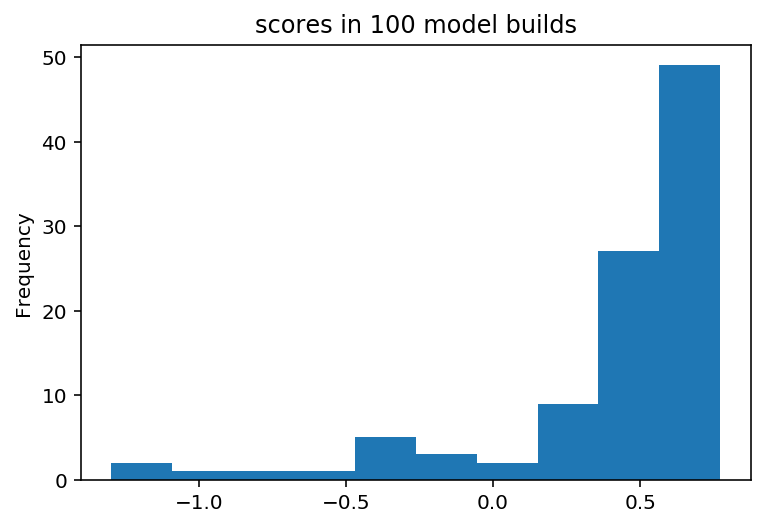

In [449]:
pd.Series(out).plot(kind='hist', title='scores in 100 model builds')

#### On 2020

In [450]:
X20 = data_20.drop(['Impressions'], axis=1)
y20 = data_20.Impressions

X_train, X_test, y_train, y_test = train_test_split(X20, y20, test_size=.25)

final_pl.fit(X_train, y_train)

print(2020)
r2 = final_pl.score(X_test, y_test)
print("R^2: %s" % r2)

final_preds = final_pl.predict(X_test)
rmse = np.sqrt(np.mean((final_preds - y_test)**2))
print("RMSE: %s" % rmse)

2020
R^2: 0.4533685046606899
RMSE: 2626097.322470323


In [451]:
out = []
for _ in range(100):
    X_tr, X_ts, y_tr, y_ts = train_test_split(X20, y20)
    final_pl.fit(X_tr, y_tr)
    out.append(final_pl.score(X_ts, y_ts))
mean_r2 = np.mean(out)
print("Mean R^2 across 100 reps: %s" % mean_r2)

/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Big Box Store Buyers - Walmart', 'Black Friday & Cyber Monday Shoppers', 'Last 12 Months Buyers - Walmart', 'Mexican Food Shoppers', 'Pet Owners', 'Post-Holiday Bargain Shoppers', 'Soul & R&B Fans', 'TV Network Viewers (FX)', 'Vegans & Organic Foodies'] will be ignored
  .format(sorted(unknown, key=str)))
/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Baby & Toddler - Baby Food Buyers', 'Baby & Toddler - Baby Formula Buyers', 'Baby & Toddler - Baby HBC Buyers', 'Baby & Toddler - Baby HBC Buyers - Huggies Brands', 'Baby & Toddler - Disposable Diaper & Training Pant Buyers', 'Baby & Toddler - Disposable Diaper & Training Pant Buyers - Huggies Brands', 'Baby & Toddler - Disposable Diaper & Training Pant Buyers - Pampers Brands', 'Baby Product Buyers', 'Baby Store Buyers', 'Baby Store Buyer

/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Apparel Store Buyers - Charlotte Russe', 'Apparel Store Buyers - Express', 'Apparel Store Buyers - Guess', 'Apparel Store Buyers - H & M', 'Apparel Store Buyers - Michael Kors', 'Apparel Store Buyers - TJ Maxx', 'Apparel Store Buyers - Victorias Secret', 'Baby & Toddler - Baby Food Buyers', 'Baby & Toddler - Baby Formula Buyers', 'Baby & Toddler - Baby HBC Buyers', 'Baby & Toddler - Baby HBC Buyers - Huggies Brands', 'Baby & Toddler - Disposable Diaper & Training Pant Buyers', 'Baby & Toddler - Disposable Diaper & Training Pant Buyers - Huggies Brands', 'Baby & Toddler - Disposable Diaper & Training Pant Buyers - Pampers Brands', 'Baby Product Buyers', 'Baby Store Buyers', 'Baby Store Buyers - Buy Buy Baby', 'Baby Store Buyers - Carters', 'Baby Store Buyers - Diapers.com', 'Beauty and Fragrance Shoppers', 'Black Friday & Cyber Monday Shoppers', 'Black Friday Onli

/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Action & Thriller Genre Fans', 'Apparel Store Buyers - Charlotte Russe', 'Apparel Store Buyers - Express', 'Apparel Store Buyers - Guess', 'Apparel Store Buyers - H & M', 'Apparel Store Buyers - Michael Kors', 'Apparel Store Buyers - TJ Maxx', 'Apparel Store Buyers - Victorias Secret', 'Baby & Toddler - Baby Food Buyers', 'Baby & Toddler - Baby Formula Buyers', 'Baby & Toddler - Baby HBC Buyers', 'Baby & Toddler - Baby HBC Buyers - Huggies Brands', 'Baby & Toddler - Disposable Diaper & Training Pant Buyers', 'Baby & Toddler - Disposable Diaper & Training Pant Buyers - Huggies Brands', 'Baby & Toddler - Disposable Diaper & Training Pant Buyers - Pampers Brands', 'Baby Product Buyers', 'Baby Store Buyers', 'Baby Store Buyers - Buy Buy Baby', 'Baby Store Buyers - Carters', 'Baby Store Buyers - Diapers.com', 'Beauty and Fragrance Shoppers', "Children's Product Buyers

/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Apparel Store Buyers - Charlotte Russe', 'Apparel Store Buyers - Express', 'Apparel Store Buyers - Guess', 'Apparel Store Buyers - H & M', 'Apparel Store Buyers - Michael Kors', 'Apparel Store Buyers - TJ Maxx', 'Apparel Store Buyers - Victorias Secret', 'Baby & Toddler - Baby Food Buyers', 'Baby & Toddler - Baby Formula Buyers', 'Baby & Toddler - Baby HBC Buyers', 'Baby & Toddler - Baby HBC Buyers - Huggies Brands', 'Baby & Toddler - Disposable Diaper & Training Pant Buyers', 'Baby & Toddler - Disposable Diaper & Training Pant Buyers - Huggies Brands', 'Baby & Toddler - Disposable Diaper & Training Pant Buyers - Pampers Brands', 'Baby Product Buyers', 'Baby Store Buyers', 'Baby Store Buyers - Buy Buy Baby', 'Baby Store Buyers - Carters', 'Baby Store Buyers - Diapers.com', 'Beauty and Fragrance Shoppers', "Children's Product Buyers", "Children's Product Shoppers"

/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Apparel Store Buyers - Charlotte Russe', 'Apparel Store Buyers - Express', 'Apparel Store Buyers - Guess', 'Apparel Store Buyers - H & M', 'Apparel Store Buyers - Michael Kors', 'Apparel Store Buyers - TJ Maxx', 'Apparel Store Buyers - Victorias Secret', 'Beauty and Fragrance Shoppers', 'Independence Day Buyers - Furnishing Stores', 'Independence Day Buyers - Grocery', 'Labor Day Buyers - Clothing Stores', 'Mexican Food Shoppers', 'Pet Owners', 'TV Network Viewers (Comedy Central)', "Women's Apparel Shoppers"] will be ignored
  .format(sorted(unknown, key=str)))
/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Apparel Buyers', 'Black Friday & Cyber Monday Shoppers', 'Black Friday Buyers', 'Black Friday Buyers - Apparel', 'Crime & Mystery Genre Fans', 'Cycling Enthusiasts', 'Deal & Value S

/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Black Friday & Cyber Monday Shoppers', 'Last 12 Months Buyers - Urban Outfitters', 'Pet Owners', 'Post-Holiday Bargain Shoppers', 'TV Network Viewers (FX)'] will be ignored
  .format(sorted(unknown, key=str)))
/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Baby & Toddler - Baby Food Buyers', 'Baby & Toddler - Baby Formula Buyers', 'Baby & Toddler - Baby HBC Buyers', 'Baby & Toddler - Baby HBC Buyers - Huggies Brands', 'Baby & Toddler - Disposable Diaper & Training Pant Buyers', 'Baby & Toddler - Disposable Diaper & Training Pant Buyers - Huggies Brands', 'Baby & Toddler - Disposable Diaper & Training Pant Buyers - Pampers Brands', 'Baby Product Buyers', 'Baby Store Buyers', 'Baby Store Buyers - Buy Buy Baby', 'Baby Store Buyers - Carters', 'Baby Store Buyers - Diapers.com', "Children's 

/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Action & Thriller Genre Fans', 'Big Box Store Buyers - Walmart', 'Comedy Fans', 'Drama Genre Fans', 'Family Genre Fans', 'Horror Genre Fans', 'Independence Day Buyers - Furnishing Stores', 'Independence Day Buyers - Grocery', 'Labor Day Buyers - Clothing Stores', 'Last 12 Months Buyers - Walmart', 'Movie Theater Goers', 'Romance & Rom-Com Fans', 'Superhero Film Fans', 'TV Network Viewers (Comedy Central)', 'Talent & Competition Show Fans'] will be ignored
  .format(sorted(unknown, key=str)))
/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Apparel Store Buyers - Charlotte Russe', 'Apparel Store Buyers - Express', 'Apparel Store Buyers - Guess', 'Apparel Store Buyers - H & M', 'Apparel Store Buyers - Michael Kors', 'Apparel Store Buyers - TJ Maxx', 'Apparel Store Buyers - Victorias Secret'

/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Black Friday Online Buyers - Amazon', 'Supermarket Buyers - Whole Foods Market'] will be ignored
  .format(sorted(unknown, key=str)))
/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Big Box Store Buyers - Walmart', 'Black Friday Online Buyers - Amazon', 'Cyber Monday Online Buyers - Amazon', 'Dallas Cowboys Fans', 'Heavy Holiday Buyers - Amazon', 'Houston Texans Fans', 'Last 12 Months Buyers - Walmart', 'New Chevrolet Truck Shoppers', 'New Ford Truck Shoppers', 'New Orleans Saints Fans', 'New RAM Truck Shoppers', 'Pet Owners', 'Soul & R&B Fans', 'Supermarket Buyers - Whole Foods Market', 'TV Viewers (Science Fiction & Fantasy)', 'Tampa Bay Buccaneers Fans', 'Tennessee Titans Fans', 'Vegans & Organic Foodies', 'Walmart Stores', 'eCommerce Buyers - Amazon - Heavy Buyers'] will be ignored
 

Mean R^2 across 100 reps: -5.7291961343206104e+16


/Users/jonathant/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['Action & Thriller Genre Fans', 'Big Box Store Buyers - Walmart', 'Comedy Fans', 'Drama Genre Fans', 'Family Genre Fans', 'Horror Genre Fans', 'Last 12 Months Buyers - Walmart', 'Movie Theater Goers', 'Romance & Rom-Com Fans', 'Soul & R&B Fans', 'Superhero Film Fans', 'Supermarket Buyers - Whole Foods Market', 'Talent & Competition Show Fans'] will be ignored
  .format(sorted(unknown, key=str)))


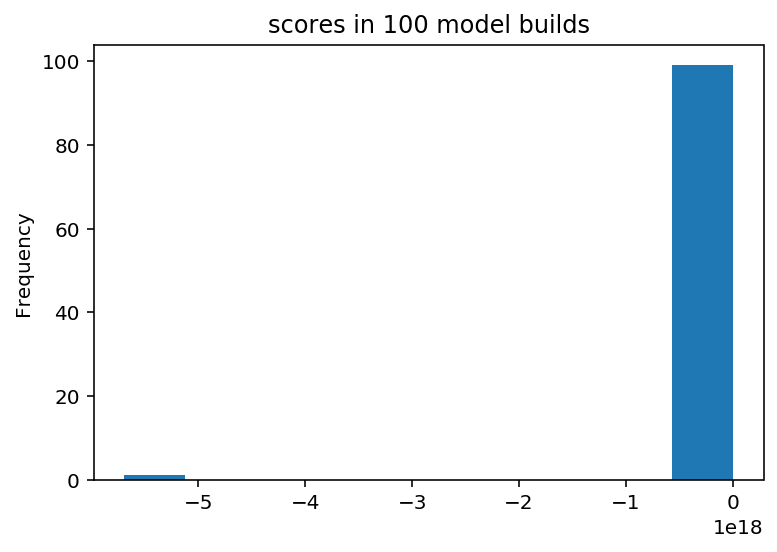

In [452]:
pd.Series(out).plot(kind='hist', title='scores in 100 model builds')

One interesting observation here is the difference in how the model predicted impressions for data on 2019 and 2020. It seems to be doing better for the year 2019 than 2020 by quite a margin. The mean R^2 value for the 2020 model is negative. One reason to explain this is probably the fact that 2020 is still the current year so there is not sufficient data to model it. Whereas 2019 data make up for most of the main dataset which created the model so it results in a higher accuracy.